# Scaling and Efficiency

In [1]:
# Defaults
strong_scaling_book_path = '../runs/strong_scaling'
weak_scaling_book_path = '../runs/weak_scaling'

In [2]:
import scrapbook as sb
import matplotlib.pyplot as plt
import mhpc_project.plots as plots

In [3]:
strong_scaling_book = sb.read_notebooks(strong_scaling_book_path)

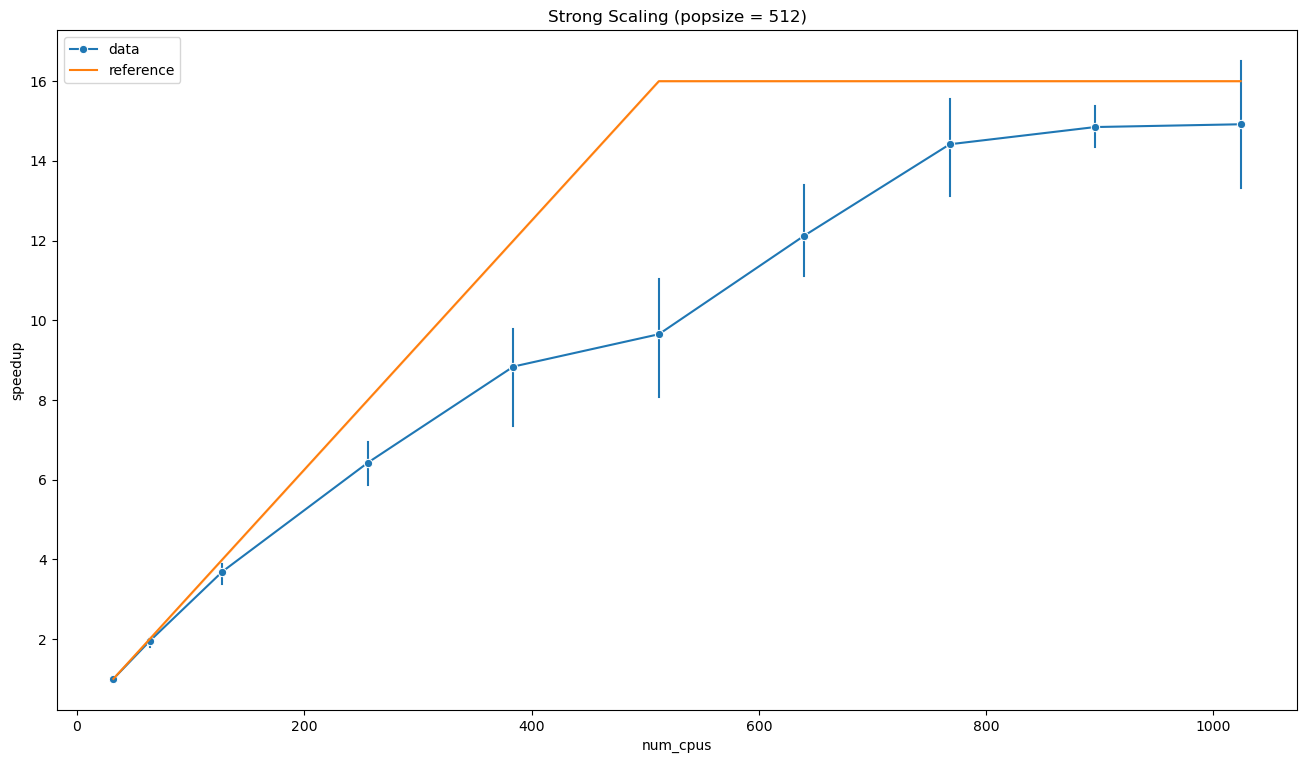

In [4]:
plots.strong_scaling(strong_scaling_book, title='Strong Scaling (popsize = 512)')
plt.show()

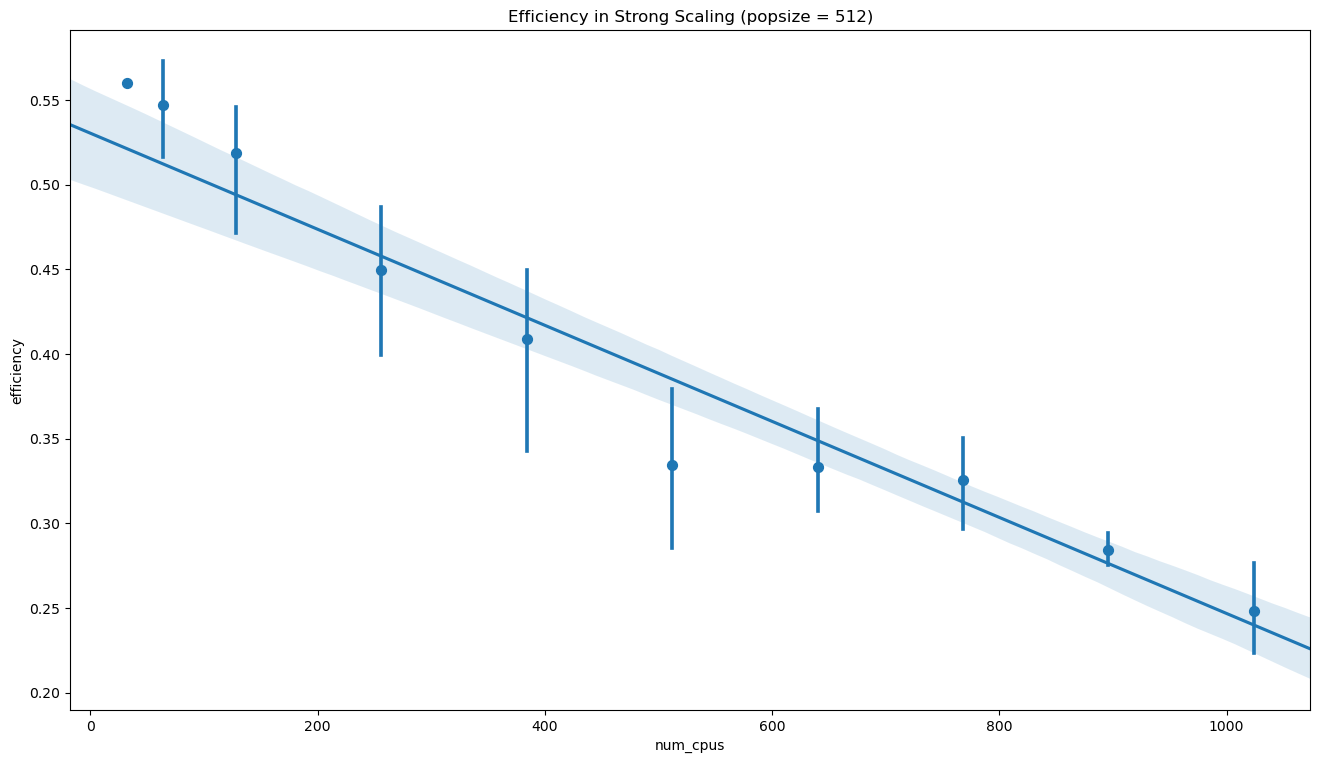

In [5]:
plots.efficiency(strong_scaling_book, title='Efficiency in Strong Scaling (popsize = 512)')
plt.show()

In [6]:
weak_scaling_book = sb.read_notebooks(weak_scaling_book_path)

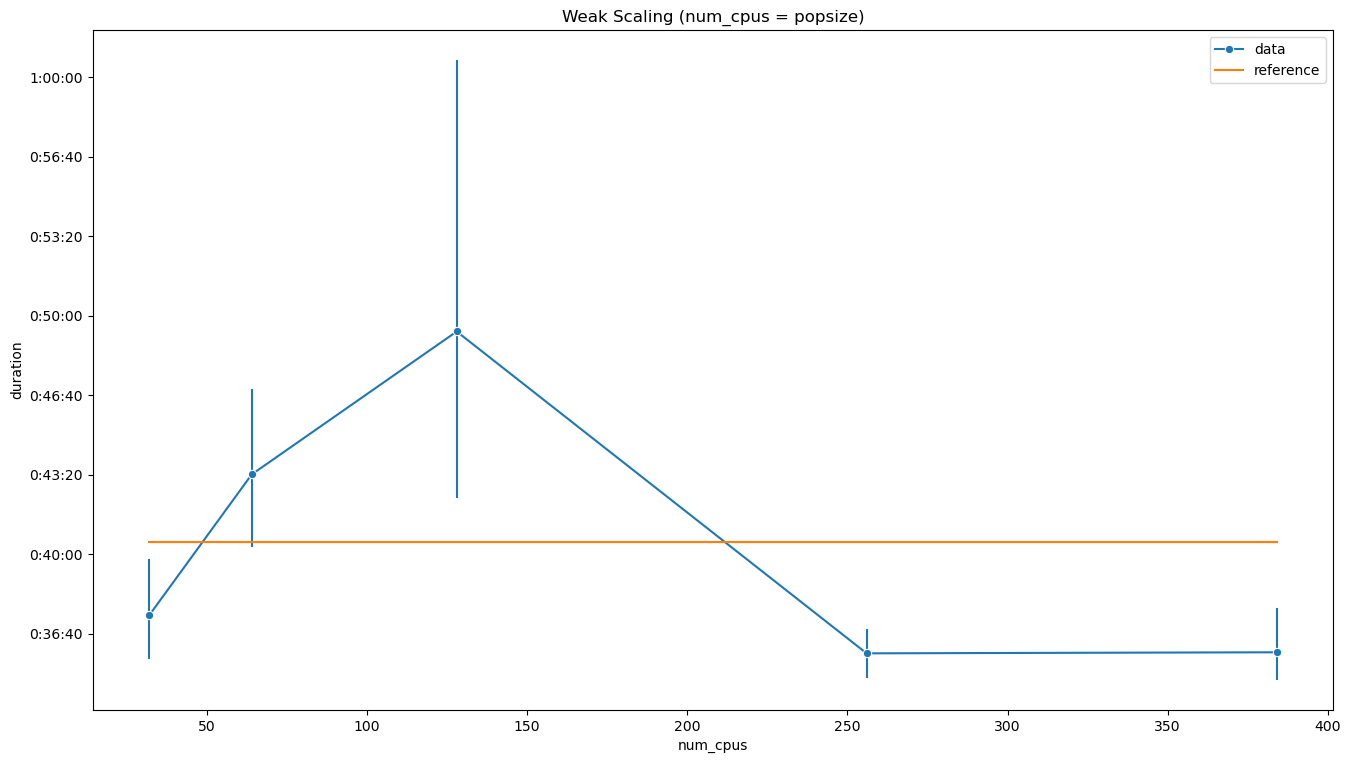

In [7]:
plots.weak_scaling(weak_scaling_book, title='Weak Scaling (num_cpus = popsize)')
plt.show()

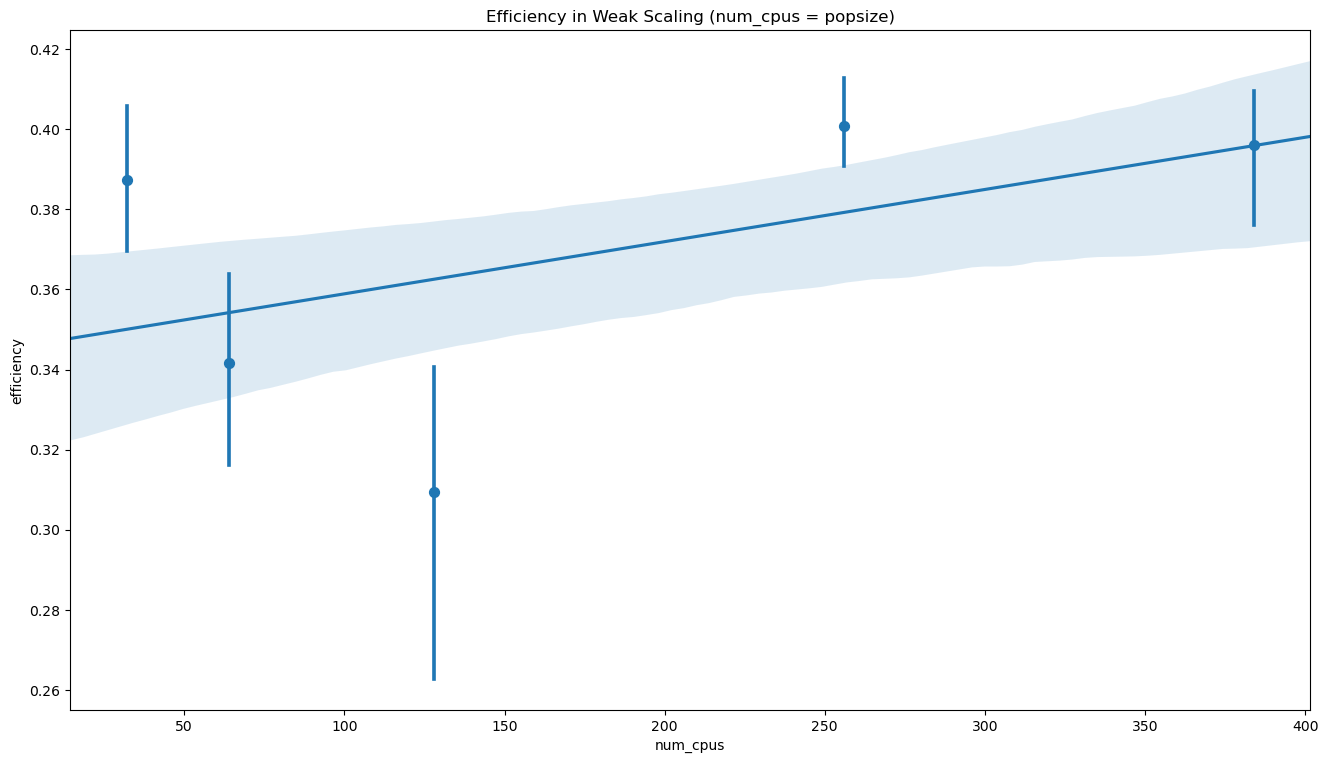

In [8]:
plots.efficiency(weak_scaling_book, title='Efficiency in Weak Scaling (num_cpus = popsize)')
plt.show()